Consider the general equation
\\[ -\mathrm{div}(A \ \mathrm{grad}(w)) + b \cdot \mathrm{grad}(w) + c\ w = 1. \\]

In [1]:
import numpy as np
import pandas as pd
import sys

sys.path.insert(1, "/Users/gpin/Repos/EVErrorEst/scripts")
from ngsolve import *

# from main_utils import *
from adapt import *
from error import *
from ngsolve.webgui import Draw
import matplotlib.pyplot as plt

# Adaptivity

In [34]:
parameters = {
    "order": 2,
    "maxiter": 100,
    "maxndofs": 200_000,
    "center": 5 * np.pi**2 + 325,
    "radius": 0.1,
    "npts": 6,
    "nspan": 4,
    "maxh": 0.15,
    "theta": 0.5,
}

feast_parameters = {
    "hermitian": False,
    "stop_tol": 1.0e-9,
    "cut_tol": 1.0e-10,
    "eta_tol": 1e-10,
    "nrestarts": 5,
    "niterations": 100,
}

## Original Convection Diffusion, (primal) error estimator

Consider
\\[ \mathcal{L} w := -\Delta\ w + (20,30) \cdot \mathrm{grad}(w)  = 1,\\]
with a residual error estimator based on the landscape function.

It has the form
\\[\eta^2_K = h_k^2\lVert -\Delta\ w + (20,30) \cdot \mathrm{grad}(w) - 1\rVert_K^2
    + \frac{1}{2} h_k \lVert \partial_\nu w \rVert_{\partial K}^2. \\]


In [11]:
matrix = CF((1.0, 0.0, 0.0, 1.0), dims=(2, 2))
vector = CF((20.0, 30.0))
scalar = CF(0.0)

mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))

eta_dict, eig_dict, err_dict, sol = test_ard(
    parameters=parameters,
    matrix_coeff=matrix,
    vector_coeff=vector,
    scalar_coeff=scalar,
    source_coeff=None,
    **feast_parameters,
)

	Parameters: {'order': 2, 'maxiter': 100, 'maxndofs': 200000, 'center': 374.3480220054468, 'radius': 0.1, 'npts': 6, 'nspan': 4, 'maxh': 0.15, 'theta': 0.5}

SpectralProj: Setting shifted trapezoidal rule quadrature on circular contour
SpectralProj: Radius=0.01, Center=374.348+0j

SpectralProjNG: Computing resolvents using umfpack
SpectralProjNG:   Factorizing at z = +374.355 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 -0.007j
SpectralProjNG:   Factorizing at z = +374.355 -0.007j

=========== Starting FEAST iterations ===========
Trying with 2 vectors:

 ITERATION 1 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [2.0e-27 9.5e-19]
   Real part of computed eigenvalues:
   [377.88901648 378.87840721]
   Imag part of computed eigenvalues:
   [ 8.74633665e-08 -1.24488619e+01]
   Relative Hausdorff distance from prior iterate: 2.671e+97

 ITERATION 2 with 2 vectors and 2 left vectors
   During kernel clea

In [12]:
Draw(sol["u"], sol["mesh"], name="Landscape function")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [13]:
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

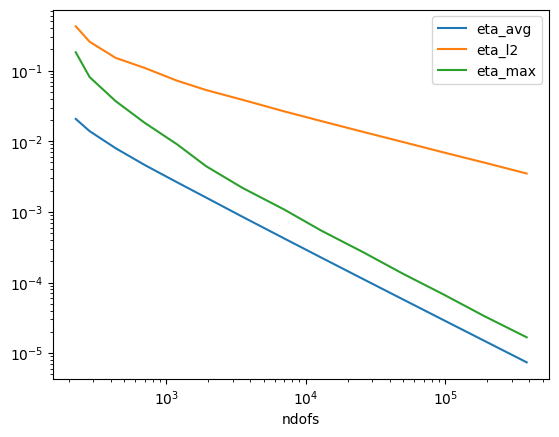

In [14]:
eta_df.plot(x="ndofs", loglog=True)

In [15]:
get_numerical_error_order(eta_df, eta_df.columns.drop(["eta_avg", "eta_max"]))
get_numerical_error_order(eta_df, eta_df.columns.drop(["eta_avg", "eta_l2"]))
get_numerical_error_order(eta_df, eta_df.columns.drop(["eta_max", "eta_l2"]))
print(eta_df[eta_df.columns.drop(["eta_avg", "eta_max", "eta_l2"])])

     ndofs  eta_l2_order  eta_max_order  eta_avg_order
0      225      0.000000       0.000000       0.000000
1      283      2.198156       3.531689       1.742200
2      434      1.224636       1.823591       1.294467
3      701      0.684985       1.476505       1.141760
4     1201      0.777572       1.311742       1.055402
5     1934      0.634944       1.489493       1.038373
6     3520      0.529446       1.177261       1.044292
7     7010      0.547689       1.024368       1.025844
8    13000      0.517225       1.123848       1.020078
9    25786      0.510511       1.016667       1.013056
10   49312      0.500731       1.069809       1.008981
11   98143      0.507532       1.009020       1.006468
12  189935      0.494124       1.050329       1.004440
13  383095      0.508253       0.988015       1.003064


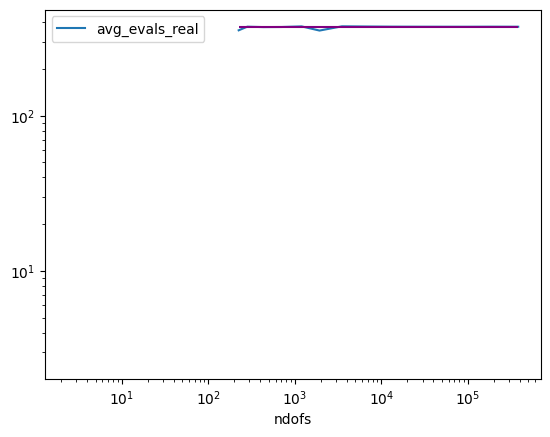

In [22]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=225, xmax=383095, color="purple", label="test")

<Axes: xlabel='ndofs'>

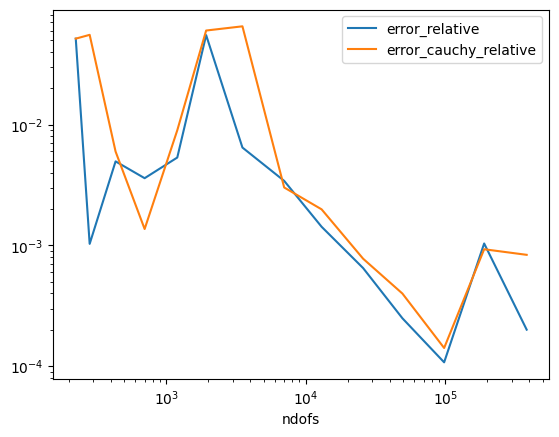

In [23]:
err_df.plot(
    x="ndofs",
    y=err_df.columns.drop(["ndofs", "error_cauchy", "error_avg"]),
    loglog=True,
)

In [24]:
get_numerical_error_order(
    err_df,
    err_df.columns.drop(["error_cauchy", "error_relative", "error_cauchy_relative"]),
)
get_numerical_error_order(
    err_df, err_df.columns.drop(["error_cauchy", "error_avg", "error_cauchy_relative"])
)
print(
    err_df[
        err_df.columns.drop(
            ["error_avg", "error_cauchy", "error_relative", "error_cauchy_relative"]
        )
    ]
)

     ndofs  error_avg_order  error_relative_order
0      225         0.000000              0.000000
1      283        17.054152             17.054152
2      434        -3.676944             -3.676944
3      701         0.668311              0.668311
4     1201        -0.730889             -0.730889
5     1934        -4.897609             -4.897609
6     3520         3.578326              3.578326
7     7010         0.922041              0.922041
8    13000         1.416869              1.416869
9    25786         1.149290              1.149290
10   49312         1.475529              1.475529
11   98143         1.219466              1.219466
12  189935        -3.430161             -3.430161
13  383095         2.340603              2.340603


## Self-adjoint convection-diffusion problem, (primal) error estimator

Consider
\\( \tilde {\mathcal{L}} w := \exp(-\phi) \mathcal{L} \exp{\phi}\\).
This is,
\\[ -\Delta\ w + \frac{20^2 + 30^2}{4} w  = 1,\\]
with a residual error estimator based on the landscape function.

It has the form
\\[\eta^2_K = h_K^2\left\lVert -\Delta\ w + \frac{20^2 + 30^2}{4} w - 1\right\rVert_K^2
    + \frac{1}{2} h_K \lVert \partial_\nu w \rVert_{\partial K}^2. \\]


In [25]:
matrix = CF((1.0, 0.0, 0.0, 1.0), dims=(2, 2))
vector = CF((0.0, 0.0))
scalar = CF(325.0)

mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))

eta_dict, eig_dict, err_dict, sol = test_ard(
    parameters=parameters,
    matrix_coeff=matrix,
    vector_coeff=vector,
    scalar_coeff=scalar,
    source_coeff=None,
    **feast_parameters,
)

	Parameters: {'order': 2, 'maxiter': 100, 'maxndofs': 200000, 'center': 374.3480220054468, 'radius': 0.1, 'npts': 6, 'nspan': 4, 'maxh': 0.15, 'theta': 0.5}

SpectralProj: Setting shifted trapezoidal rule quadrature on circular contour
SpectralProj: Radius=0.01, Center=374.348+0j

SpectralProjNG: Computing resolvents using umfpack
SpectralProjNG:   Factorizing at z = +374.355 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 -0.007j
SpectralProjNG:   Factorizing at z = +374.355 -0.007j

=========== Starting FEAST iterations ===========
Trying with 2 vectors:

 ITERATION 1 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [1.e-08 5.e-09]
   Real part of computed eigenvalues:
   [374.40231906 374.40515011]
   Relative Hausdorff distance from prior iterate: 2.671e+97

 ITERATION 2 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [157.7 133.3]
   Real part of computed eigenvalues:
   [374.4

In [26]:
Draw(sol["u"], sol["mesh"], name="Landscape function")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [27]:
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

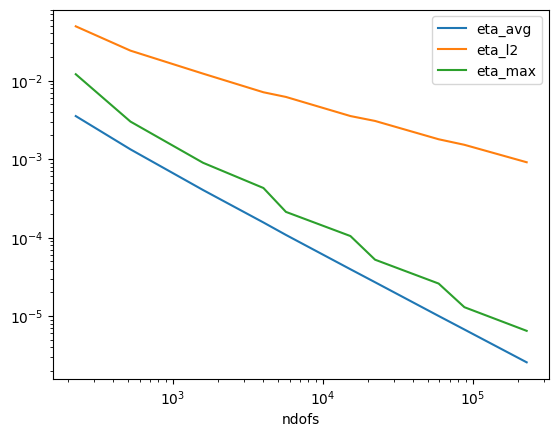

In [28]:
eta_df.plot(x="ndofs", loglog=True)

In [29]:
get_numerical_error_order(eta_df, eta_df.columns.drop(["eta_avg", "eta_max"]))
get_numerical_error_order(eta_df, eta_df.columns.drop(["eta_avg", "eta_l2"]))
get_numerical_error_order(eta_df, eta_df.columns.drop(["eta_max", "eta_l2"]))
print(eta_df[eta_df.columns.drop(["eta_avg", "eta_max", "eta_l2"])])

    ndofs  eta_l2_order  eta_max_order  eta_avg_order
0     225      0.000000       0.000000       0.000000
1     521      0.849622       1.654021       1.162731
2    1589      0.605210       1.084492       1.070128
3    4017      0.589233       0.798068       1.026944
4    5677      0.397726       2.027263       1.057144
5   15281      0.566156       0.715634       1.016889
6   22307      0.379996       1.834089       1.007779
7   59217      0.550340       0.717220       1.013712
8   87955      0.411052       1.752896       1.003758
9  228896      0.535229       0.725690       1.006737


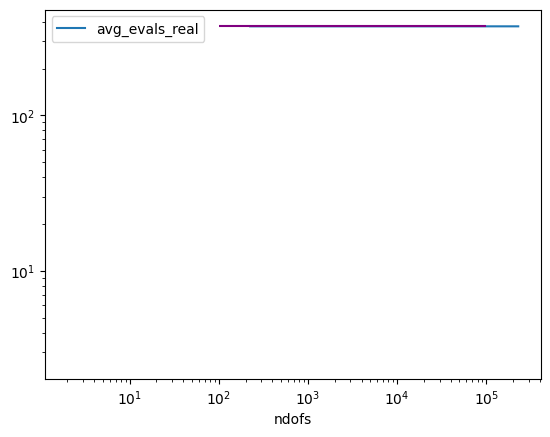

In [30]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

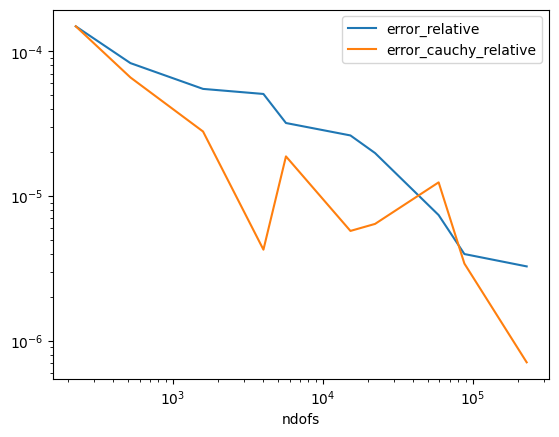

In [31]:
err_df.plot(
    x="ndofs",
    y=err_df.columns.drop(["ndofs", "error_cauchy", "error_avg"]),
    loglog=True,
)

In [32]:
get_numerical_error_order(
    err_df,
    err_df.columns.drop(["error_cauchy", "error_relative", "error_cauchy_relative"]),
)
get_numerical_error_order(
    err_df, err_df.columns.drop(["error_cauchy", "error_avg", "error_cauchy_relative"])
)
print(
    err_df[
        err_df.columns.drop(
            ["error_avg", "error_cauchy", "error_relative", "error_cauchy_relative"]
        )
    ]
)

    ndofs  error_avg_order  error_relative_order
0     225         0.000000              0.000000
1     521         0.697412              0.697412
2    1589         0.368128              0.368128
3    4017         0.086861              0.086861
4    5677         1.336825              1.336825
5   15281         0.199789              0.199789
6   22307         0.741529              0.741529
7   59217         1.011073              1.011073
8   87955         1.567813              1.567813
9  228896         0.205506              0.205506


## Original Convection Diffusion, mixed error estimator

Consider
\\[ \mathcal{L} w := -\Delta\ w + (20,30) \cdot \mathrm{grad}(w)  = 1,\\]
with a residual error estimator based on the landscape function and *its dual*.

It has the form
\\[\eta^2_K = h_k^2\lVert -\Delta\ w + (20,30) \cdot \mathrm{grad}(w) - 1\rVert_K^2
    + \frac{1}{2} h_k \lVert \partial_\nu w \rVert_{\partial K}^2, \\]
    and (TODO)
\\[\eta^2_{K,d} = h_k^2\lVert -\Delta\ w + (20,30) \cdot \mathrm{grad}(w) - 1\rVert_K^2
    + \frac{1}{2} h_k \lVert \partial_\nu w \rVert_{\partial K}^2. \\]


In [35]:
matrix = CF((1.0, 0.0, 0.0, 1.0), dims=(2, 2))
vector = CF((20.0, 30.0))
scalar = CF(0.0)

mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))

eta_dict, eig_dict, err_dict, sol = test_ard_dual(
    parameters=parameters,
    matrix_coeff=matrix,
    vector_coeff=vector,
    scalar_coeff=scalar,
    source_coeff=None,
    **feast_parameters,
)

	Parameters: {'order': 2, 'maxiter': 100, 'maxndofs': 200000, 'center': 374.3480220054468, 'radius': 0.1, 'npts': 6, 'nspan': 4, 'maxh': 0.15, 'theta': 0.5}

SpectralProj: Setting shifted trapezoidal rule quadrature on circular contour
SpectralProj: Radius=0.01, Center=374.348+0j

SpectralProjNG: Computing resolvents using umfpack
SpectralProjNG:   Factorizing at z = +374.355 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 -0.007j
SpectralProjNG:   Factorizing at z = +374.355 -0.007j

=========== Starting FEAST iterations ===========
Trying with 2 vectors:

 ITERATION 1 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [2.0e-27 9.5e-19]
   Real part of computed eigenvalues:
   [377.88901648 378.87840721]
   Imag part of computed eigenvalues:
   [ 8.74633665e-08 -1.24488619e+01]
   Relative Hausdorff distance from prior iterate: 2.671e+97

 ITERATION 2 with 2 vectors and 2 left vectors
   During kernel clea

In [36]:
Draw(sol["u"], sol["mesh"], name="Landscape function")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [37]:
Draw(sol["v"], sol["mesh"], name="Dual landscape function")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [38]:
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

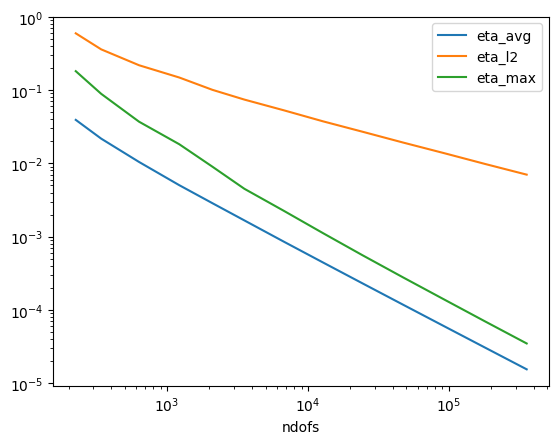

In [39]:
eta_df.plot(x="ndofs", loglog=True)

In [40]:
get_numerical_error_order(eta_df, eta_df.columns.drop(["eta_avg", "eta_max"]))
get_numerical_error_order(eta_df, eta_df.columns.drop(["eta_avg", "eta_l2"]))
get_numerical_error_order(eta_df, eta_df.columns.drop(["eta_max", "eta_l2"]))
print(eta_df[eta_df.columns.drop(["eta_avg", "eta_max", "eta_l2"])])

     ndofs  eta_l2_order  eta_max_order  eta_avg_order
0      225      0.000000       0.000000       0.000000
1      341      1.213745       1.714501       1.420012
2      633      0.807111       1.416522       1.185568
3     1221      0.586907       1.078162       1.110768
4     2098      0.715115       1.303922       1.045107
5     3540      0.587605       1.329783       1.037057
6     6768      0.522350       1.074684       1.036343
7    12792      0.541840       1.096168       1.022649
8    24377      0.506585       1.076622       1.017192
9    47178      0.512857       1.050576       1.011892
10   92212      0.497391       1.034895       1.008264
11  180648      0.507914       1.031107       1.005989
12  356383      0.493822       1.020334       1.004028


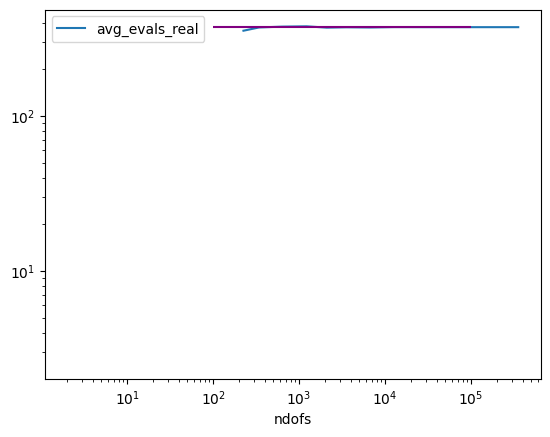

In [41]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

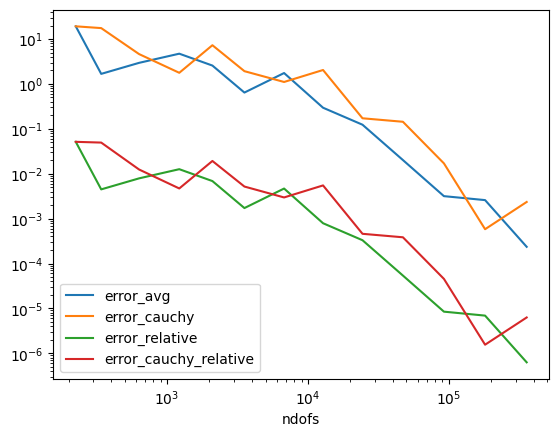

In [42]:
err_df.plot(
    x="ndofs",
    # y=err_df.columns.drop(['ndofs', 'error_cauchy', 'error_cauchy_relative']),
    loglog=True,
)

In [43]:
get_numerical_error_order(
    err_df,
    err_df.columns.drop(["error_cauchy", "error_relative", "error_cauchy_relative"]),
)
get_numerical_error_order(
    err_df, err_df.columns.drop(["error_cauchy", "error_avg", "error_cauchy_relative"])
)
print(
    err_df[
        err_df.columns.drop(
            ["error_avg", "error_cauchy", "error_relative", "error_cauchy_relative"]
        )
    ]
)

     ndofs  error_avg_order  error_relative_order
0      225         0.000000              0.000000
1      341         5.866373              5.866373
2      633        -0.913745             -0.913745
3     1221        -0.715755             -0.715755
4     2098         1.125152              1.125152
5     3540         2.647404              2.647404
6     6768        -1.544732             -1.544732
7    12792         2.794680              2.794680
8    24377         1.352034              1.352034
9    47178         2.745294              2.745294
10   92212         2.762957              2.762957
11  180648         0.301614              0.301614
12  356383         3.526411              3.526411


## Self-adjoint Convection Diffusion, mixed error estimator

Consider
\\( \tilde {\mathcal{L}} w := \exp(-\phi) \mathcal{L} \exp{\phi}\\).
This is,
\\[ -\Delta\ w + \frac{20^2 + 30^2}{4} w  = 1,\\]
with a residual error estimator based on the landscape function.

It has the form
\\[\eta^2_K = h_K^2\left\lVert -\Delta\ w + \frac{20^2 + 30^2}{4} w - 1\right\rVert_K^2
    + \frac{1}{2} h_K \lVert \partial_\nu w \rVert_{\partial K}^2. \\]


In [44]:
matrix = CF((1.0, 0.0, 0.0, 1.0), dims=(2, 2))
vector = CF((0.0, 0.0))
scalar = CF(325.0)

mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))

eta_dict, eig_dict, err_dict, sol = test_ard_dual(
    parameters=parameters,
    matrix_coeff=matrix,
    vector_coeff=vector,
    scalar_coeff=scalar,
    source_coeff=None,
    **feast_parameters,
)

	Parameters: {'order': 2, 'maxiter': 100, 'maxndofs': 200000, 'center': 374.3480220054468, 'radius': 0.1, 'npts': 6, 'nspan': 4, 'maxh': 0.15, 'theta': 0.5}

SpectralProj: Setting shifted trapezoidal rule quadrature on circular contour
SpectralProj: Radius=0.01, Center=374.348+0j

SpectralProjNG: Computing resolvents using umfpack
SpectralProjNG:   Factorizing at z = +374.355 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 -0.007j
SpectralProjNG:   Factorizing at z = +374.355 -0.007j

=========== Starting FEAST iterations ===========
Trying with 2 vectors:

 ITERATION 1 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [1.e-08 5.e-09]
   Real part of computed eigenvalues:
   [374.40231906 374.40515011]
   Relative Hausdorff distance from prior iterate: 2.671e+97

 ITERATION 2 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [157.7 133.3]
   Real part of computed eigenvalues:
   [374.4

In [45]:
Draw(sol["u"], sol["mesh"], name="Landscape function")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [46]:
Draw(sol["v"], sol["mesh"], name="Landscape function")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [55]:
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

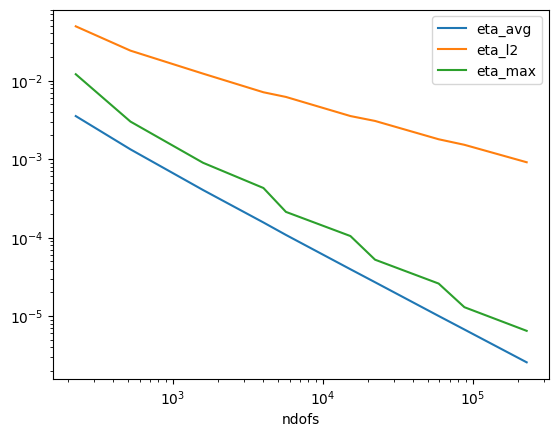

In [56]:
eta_df.plot(x="ndofs", loglog=True)

In [57]:
get_numerical_error_order(eta_df, eta_df.columns.drop(["eta_avg", "eta_max"]))
get_numerical_error_order(eta_df, eta_df.columns.drop(["eta_avg", "eta_l2"]))
get_numerical_error_order(eta_df, eta_df.columns.drop(["eta_max", "eta_l2"]))
print(eta_df[eta_df.columns.drop(["eta_avg", "eta_max", "eta_l2"])])

    ndofs  eta_l2_order  eta_max_order  eta_avg_order
0     225      0.000000       0.000000       0.000000
1     521      0.849622       1.654021       1.162731
2    1589      0.605210       1.084492       1.070128
3    4017      0.589233       0.798068       1.026944
4    5677      0.397726       2.027263       1.057144
5   15281      0.566156       0.715634       1.016889
6   22307      0.379996       1.834089       1.007779
7   59217      0.550340       0.717220       1.013712
8   87955      0.411052       1.752896       1.003758
9  228896      0.535229       0.725690       1.006737


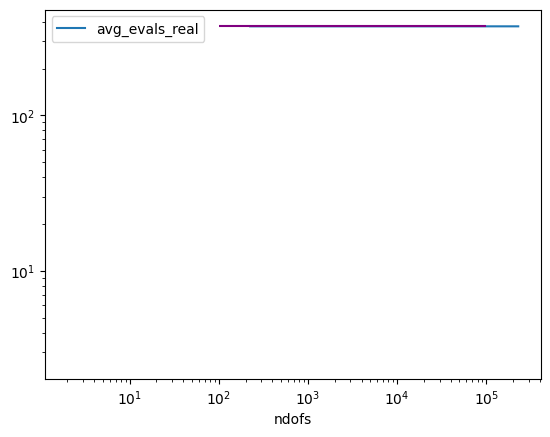

In [58]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

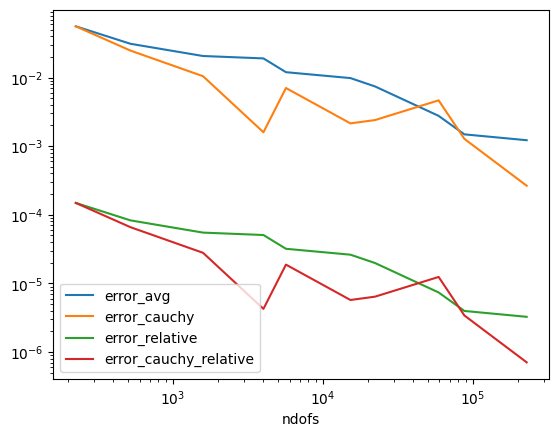

In [59]:
err_df.plot(
    x="ndofs",
    # y=err_df.columns.drop(['ndofs', 'error_cauchy', 'error_cauchy_relative']),
    loglog=True,
)

In [60]:
get_numerical_error_order(
    err_df,
    err_df.columns.drop(["error_cauchy", "error_relative", "error_cauchy_relative"]),
)
get_numerical_error_order(
    err_df, err_df.columns.drop(["error_cauchy", "error_avg", "error_cauchy_relative"])
)
print(
    err_df[
        err_df.columns.drop(
            ["error_avg", "error_cauchy", "error_relative", "error_cauchy_relative"]
        )
    ]
)

    ndofs  error_avg_order  error_relative_order
0     225         0.000000              0.000000
1     521         0.697412              0.697412
2    1589         0.368128              0.368128
3    4017         0.086861              0.086861
4    5677         1.336825              1.336825
5   15281         0.199789              0.199789
6   22307         0.741529              0.741529
7   59217         1.011073              1.011073
8   87955         1.567813              1.567813
9  228896         0.205506              0.205506


## Eigenvalue problem for the original convection diffusion eq.

### FEAST
Consider the eigenvalue problem
\\[ \mathcal{L} w := -\Delta\ w + (20,30) \cdot \mathrm{grad}(w)  = \lambda w,\\]
with a residual error estimator based on the eigenfunctions.

They have the form
\\[\eta^2_K(w_i, \lambda_i) = h_K^2 \lVert -\Delta\ w_i+ (20,30) \cdot \mathrm{grad}(w_i) - \lambda_i w_i\rVert_K^2
    + \frac{1}{2} h_K \lVert \partial_\nu w \rVert_{\partial K}^2. \\]


In [61]:
matrix = CoefficientFunction((1, 0, 0, 1), dims=(2, 2))
vector = CoefficientFunction((20, 30))
scalar = CoefficientFunction(0.0)
mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))

eta_dict, eig_dict, err_dict, sol = test_ard_eig_feast(
    parameters=parameters,
    matrix_coeff=matrix,
    vector_coeff=vector,
    scalar_coeff=scalar,
    **feast_parameters,
)

	Parameters: {'order': 2, 'maxiter': 100, 'maxndofs': 200000, 'center': 374.3480220054468, 'radius': 0.1, 'npts': 6, 'nspan': 4, 'maxh': 0.15, 'theta': 0.5}

SpectralProj: Setting shifted trapezoidal rule quadrature on circular contour
SpectralProj: Radius=0.01, Center=374.348+0j

SpectralProjNG: Computing resolvents using umfpack
SpectralProjNG:   Factorizing at z = +374.355 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 -0.007j
SpectralProjNG:   Factorizing at z = +374.355 -0.007j

=========== Starting FEAST iterations ===========
Trying with 2 vectors:

 ITERATION 1 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [1.9e-16 3.8e-10]
   Real part of computed eigenvalues:
   [373.93664014 376.17301055]
   Imag part of computed eigenvalues:
   [-4.37503002e-14 -3.15907213e-09]
   Relative Hausdorff distance from prior iterate: 2.671e+97

 ITERATION 2 with 2 vectors and 2 left vectors
   During kernel clea

In [62]:
Draw(sol["u"], sol["mesh"], name="Landscape solution")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [63]:
to_file(eta_dict, "etas_eig.csv")
to_file(eig_dict, "eval_eig.csv")
to_file(err_dict, "errs_eig.csv")
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

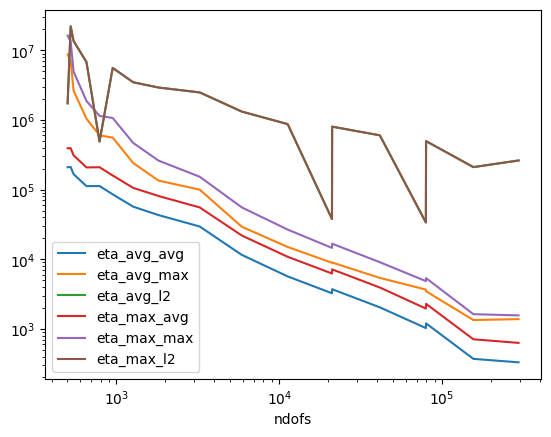

In [64]:
eta_df.plot(x="ndofs", loglog=True)

In [65]:
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_avg_l2", "eta_max_avg", "eta_max_max"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_avg_l2", "eta_max_avg", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_avg_l2", "eta_max_max", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_max_avg", "eta_max_max", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_l2", "eta_max_avg", "eta_max_max", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_max", "eta_avg_l2", "eta_max_avg", "eta_max_max", "eta_max_l2"]
    ),
)
print(
    eta_df[
        eta_df.columns.drop(
            [
                "eta_avg_avg",
                "eta_avg_max",
                "eta_avg_l2",
                "eta_max_avg",
                "eta_max_max",
                "eta_max_l2",
            ]
        )
    ]
)

     ndofs  eta_max_l2_order  eta_max_max_order  eta_max_avg_order  \
0      501          0.000000           0.000000           0.000000   
1      523        -59.309531           4.563505          -0.078733   
2      545         11.776216          24.221358           5.726627   
3      654          3.823618           5.332834           2.196629   
4      787         14.214917           2.665064          -0.036552   
5      948        -13.092926           0.376586           1.470643   
6     1267          1.633283           2.841503           1.412148   
7     1813          0.486754           1.633695           0.748540   
8     3247          0.276801           0.915638           0.649671   
9     5888          1.065256           1.702945           1.560299   
10   11272          0.638936           1.131667           1.084156   
11   21092          5.013092           0.966028           0.881266   
12   21142      -1291.298701         -58.686428         -57.167640   
13   41510          

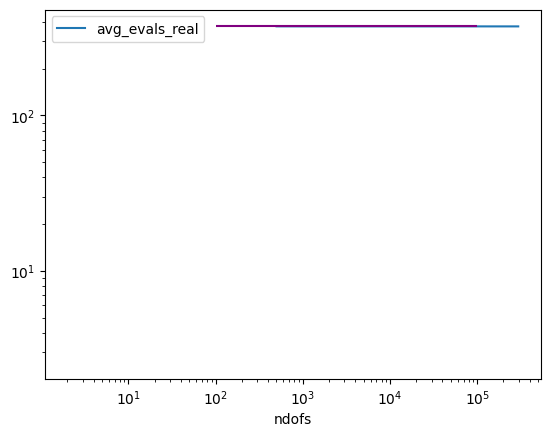

In [66]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

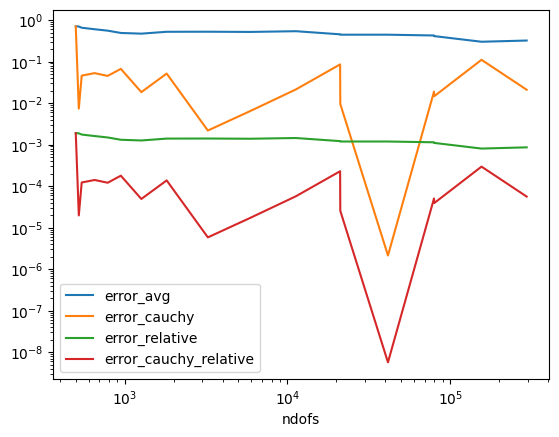

In [67]:
err_df.plot(x="ndofs", loglog=True)

In [68]:
get_numerical_error_order(
    err_df,
    err_df.columns.drop(["error_cauchy", "error_relative", "error_cauchy_relative"]),
)
get_numerical_error_order(
    err_df, err_df.columns.drop(["error_cauchy", "error_avg", "error_cauchy_relative"])
)
print(
    err_df[
        err_df.columns.drop(
            ["error_avg", "error_cauchy", "error_relative", "error_cauchy_relative"]
        )
    ]
)

     ndofs  error_avg_order  error_relative_order
0      501         0.000000              0.000000
1      523         0.243858              0.243858
2      545         1.644575              1.644575
3      654         0.460833              0.460833
4      787         0.422138              0.422138
5      948         0.687714              0.687714
6     1267         0.131901              0.131901
7     1813        -0.289328             -0.289328
8     3247        -0.007157             -0.007157
9     5888         0.020563              0.020563
10   11272        -0.062018             -0.062018
11   21092         0.275614              0.275614
12   21142         8.949111              8.949111
13   41510        -0.000007             -0.000007
14   79606         0.066437              0.066437
15   79857        11.110552             11.110552
16  155936         0.467671              0.467671
17  295365        -0.105590             -0.105590


### Arnoldi solver

We also use an Arnoldi type of solver.

In [69]:
matrix = CoefficientFunction((1, 0, 0, 1), dims=(2, 2))
vector = CoefficientFunction((20, 30))
scalar = CoefficientFunction(0.0)
mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))

eta_dict, eig_dict, err_dict, sol = test_ard_eig_arnoldi(
    parameters=parameters,
    matrix_coeff=matrix,
    vector_coeff=vector,
    scalar_coeff=scalar,
    # **kwargs,
)

	Parameters: {'order': 2, 'maxiter': 100, 'maxndofs': 200000, 'center': 374.3480220054468, 'radius': 0.1, 'npts': 6, 'nspan': 4, 'maxh': 0.15, 'theta': 0.5}


In [70]:
Draw(sol["u"], sol["mesh"], name="Landscape solution")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [71]:
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

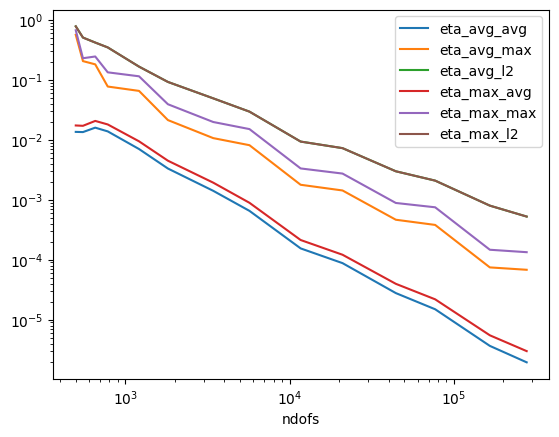

In [72]:
eta_df.plot(x="ndofs", loglog=True)

In [73]:
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_avg_l2", "eta_max_avg", "eta_max_max"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_avg_l2", "eta_max_avg", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_avg_l2", "eta_max_max", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_max_avg", "eta_max_max", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_l2", "eta_max_avg", "eta_max_max", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_max", "eta_avg_l2", "eta_max_avg", "eta_max_max", "eta_max_l2"]
    ),
)
print(
    eta_df[
        eta_df.columns.drop(
            [
                "eta_avg_avg",
                "eta_avg_max",
                "eta_avg_l2",
                "eta_max_avg",
                "eta_max_max",
                "eta_max_l2",
            ]
        )
    ]
)

     ndofs  eta_max_l2_order  eta_max_max_order  eta_max_avg_order  \
0      501          0.000000           0.000000           0.000000   
1      554          4.295151          10.680275           0.131367   
2      658          1.113724          -0.390071          -1.092064   
3      784          1.066477           3.472440           0.774021   
4     1215          1.683796           0.347509           1.478788   
5     1821          1.453507           2.652507           1.840317   
6     3434          0.993459           1.075430           1.329169   
7     5704          1.005636           0.536773           1.524226   
8    11677          1.604757           2.109127           1.994559   
9    20997          0.430202           0.336026           0.964633   
10   44288          1.190741           1.512571           1.496322   
11   76827          0.651150           0.301922           1.080892   
12  165237          1.254607           2.129051           1.804555   
13  276717          

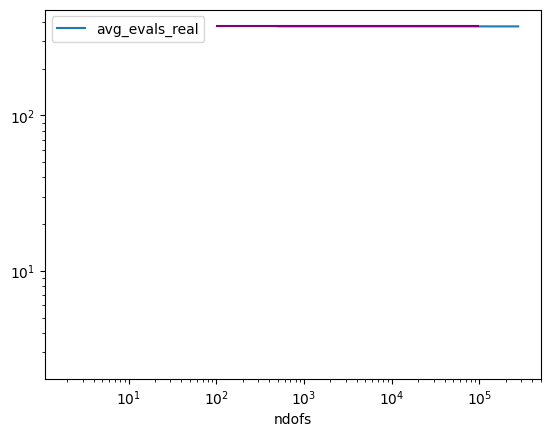

In [74]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

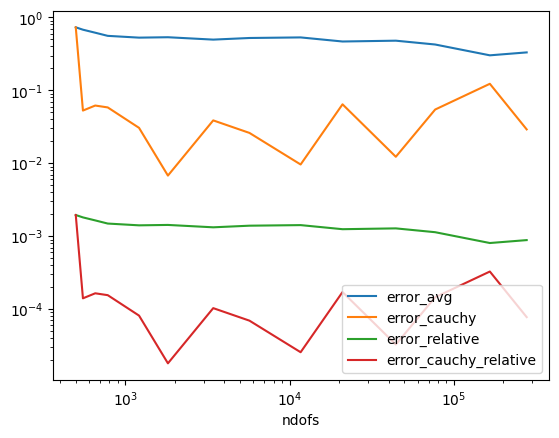

In [75]:
err_df.plot(x="ndofs", loglog=True)

In [76]:
get_numerical_error_order(
    err_df,
    err_df.columns.drop(["error_cauchy", "error_relative", "error_cauchy_relative"]),
)
get_numerical_error_order(
    err_df, err_df.columns.drop(["error_cauchy", "error_avg", "error_cauchy_relative"])
)
print(
    err_df[
        err_df.columns.drop(
            ["error_avg", "error_cauchy", "error_relative", "error_cauchy_relative"]
        )
    ]
)

     ndofs  error_avg_order  error_relative_order
0      501         0.000000              0.000000
1      554         0.745811              0.745811
2      658         0.553449              0.553449
3      784         0.566000              0.566000
4     1215         0.128525              0.128525
5     1821        -0.031516             -0.031516
6     3434         0.118354              0.118354
7     5704        -0.100930             -0.100930
8    11677        -0.025427             -0.025427
9    20997         0.219842              0.219842
10   44288        -0.034654             -0.034654
11   76827         0.219276              0.219276
12  165237         0.445950              0.445950
13  276717        -0.178708             -0.178708


## Eigenvalue problem for the self-adjoint eq.

Consider the eigenvalue problem
\\[ \tilde{\mathcal{L}} w := -\Delta\ w + \frac{20^2 + 30^2}{4} w  = \lambda w,\\]
with a residual error estimator based on the eigenfunctions.

They have the form
\\[\eta^2_K(w_i, \lambda_i) = h_K^2 \lVert -\Delta\ w_i+  \frac{20^2 + 30^2}{4}w  - \lambda_i w_i\rVert_K^2
    + \frac{1}{2} h_K \lVert \partial_\nu w \rVert_{\partial K}^2. \\]


### FEAST

In [77]:
matrix = CoefficientFunction((1, 0, 0, 1), dims=(2, 2))
vector = CoefficientFunction((0.0, 0.0))
scalar = CoefficientFunction(325.0)
mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))

eta_dict, eig_dict, err_dict, sol = test_ard_eig_feast(
    parameters=parameters,
    matrix_coeff=matrix,
    vector_coeff=vector,
    scalar_coeff=scalar,
    **feast_parameters
)

	Parameters: {'order': 2, 'maxiter': 100, 'maxndofs': 200000, 'center': 374.3480220054468, 'radius': 0.1, 'npts': 6, 'nspan': 4, 'maxh': 0.15, 'theta': 0.5}

SpectralProj: Setting shifted trapezoidal rule quadrature on circular contour
SpectralProj: Radius=0.01, Center=374.348+0j

SpectralProjNG: Computing resolvents using umfpack
SpectralProjNG:   Factorizing at z = +374.355 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 -0.007j
SpectralProjNG:   Factorizing at z = +374.355 -0.007j

=========== Starting FEAST iterations ===========
Trying with 2 vectors:

 ITERATION 1 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [3.2e-05 6.8e-04]
   Real part of computed eigenvalues:
   [374.35759663 374.35851288]
   Relative Hausdorff distance from prior iterate: 2.671e+97

 ITERATION 2 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [3783.4  323.1]
   Real part of computed eigenvalues:
   [3

In [78]:
Draw(sol["u"], sol["mesh"], name="Landscape solution")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [79]:
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

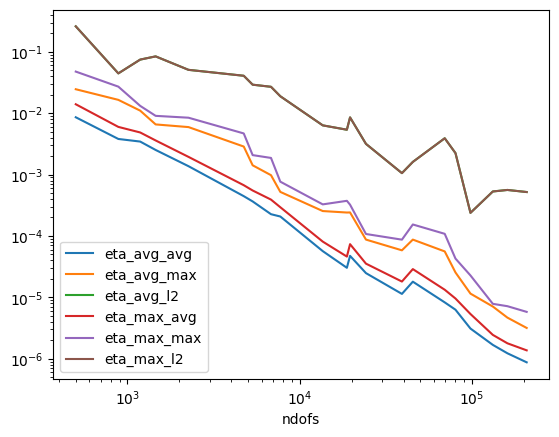

In [80]:
eta_df.plot(x="ndofs", loglog=True)

In [81]:
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_avg_l2", "eta_max_avg", "eta_max_max"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_avg_l2", "eta_max_avg", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_avg_l2", "eta_max_max", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_max_avg", "eta_max_max", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_l2", "eta_max_avg", "eta_max_max", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_max", "eta_avg_l2", "eta_max_avg", "eta_max_max", "eta_max_l2"]
    ),
)
print(
    eta_df[
        eta_df.columns.drop(
            [
                "eta_avg_avg",
                "eta_avg_max",
                "eta_avg_l2",
                "eta_max_avg",
                "eta_max_max",
                "eta_max_l2",
            ]
        )
    ]
)

     ndofs  eta_max_l2_order  eta_max_max_order  eta_max_avg_order  \
0      501          0.000000           0.000000           0.000000   
1      885          3.103101           0.992531           1.493343   
2     1185         -1.772878           2.470867           0.715096   
3     1457         -0.580926           1.813460           1.450744   
4     2260          1.149291           0.158522           1.403092   
5     4729          0.301034           0.799329           1.438697   
6     5327          2.809141           6.829011           1.668707   
7     6807          0.323810           0.430777           1.394222   
8     7711          2.847240           7.145203           2.299405   
9    13595          1.925054           1.501721           2.273381   
10   18766          0.508037          -0.414042           1.741866   
11   19578        -10.911324           3.408363         -10.991989   
12   24218          4.669352           5.171692           3.435984   
13   39161          

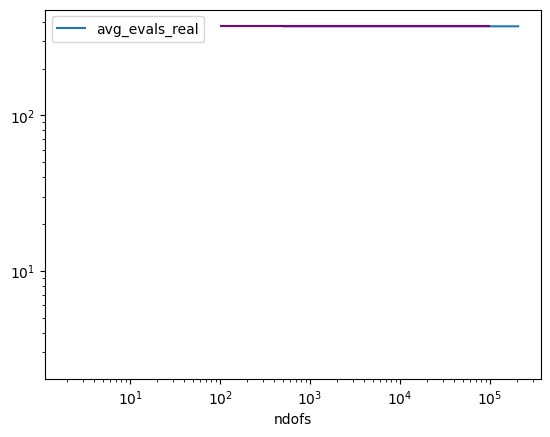

In [82]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

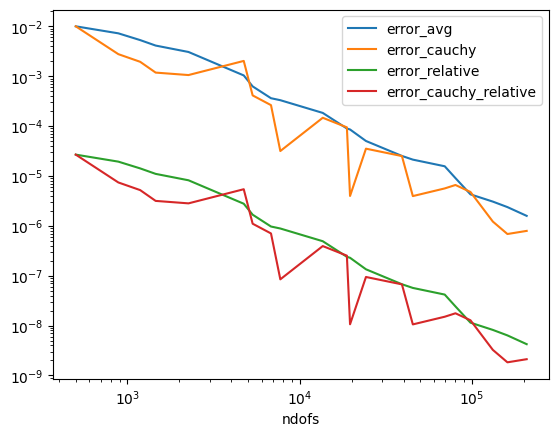

In [83]:
err_df.plot(x="ndofs", loglog=True)

In [84]:
get_numerical_error_order(
    err_df,
    err_df.columns.drop(["error_cauchy", "error_relative", "error_cauchy_relative"]),
)
get_numerical_error_order(
    err_df, err_df.columns.drop(["error_cauchy", "error_avg", "error_cauchy_relative"])
)
print(
    err_df[
        err_df.columns.drop(
            ["error_avg", "error_cauchy", "error_relative", "error_cauchy_relative"]
        )
    ]
)

     ndofs  error_avg_order  error_relative_order
0      501         0.000000              0.000000
1      885         0.568920              0.568920
2     1185         1.070989              1.070989
3     1457         1.221101              1.221101
4     2260         0.674141              0.674141
5     4729         1.466875              1.466875
6     5327         4.253856              4.253856
7     6807         2.227054              2.227054
8     7711         0.732248              0.732248
9    13595         1.035506              1.035506
10   18766         2.233496              2.233496
11   19578         1.070150              1.070150
12   24218         2.498515              2.498515
13   39161         1.436255              1.436255
14   45311         1.167143              1.167143
15   69389         0.720597              0.720597
16   80098         3.812087              3.812087
17   97882         3.739157              3.739157
18  131987         1.119983              1.119983


### Arnoldi

In [85]:
matrix = CoefficientFunction((1, 0, 0, 1), dims=(2, 2))
vector = CoefficientFunction((0.0, 0.0))
scalar = CoefficientFunction(325.0)
mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))

eta_dict, eig_dict, err_dict, sol = test_ard_eig_arnoldi(
    parameters=parameters,
    matrix_coeff=matrix,
    vector_coeff=vector,
    scalar_coeff=scalar,
    # **kwargs,
)

	Parameters: {'order': 2, 'maxiter': 100, 'maxndofs': 200000, 'center': 374.3480220054468, 'radius': 0.1, 'npts': 6, 'nspan': 4, 'maxh': 0.15, 'theta': 0.5}


In [86]:
Draw(sol["u"], sol["mesh"], name="Landscape solution")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [87]:
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

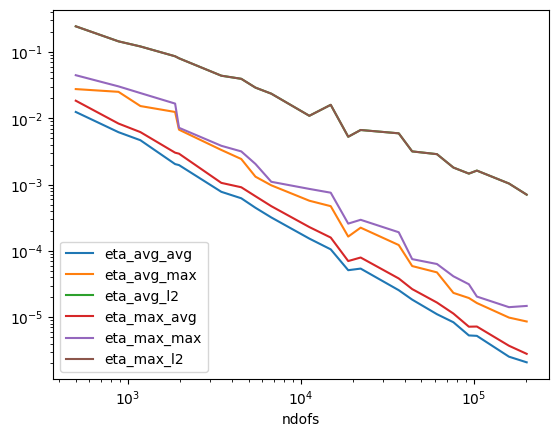

In [88]:
eta_df.plot(x="ndofs", loglog=True)

In [89]:
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_avg_l2", "eta_max_avg", "eta_max_max"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_avg_l2", "eta_max_avg", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_avg_l2", "eta_max_max", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_max_avg", "eta_max_max", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_l2", "eta_max_avg", "eta_max_max", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_max", "eta_avg_l2", "eta_max_avg", "eta_max_max", "eta_max_l2"]
    ),
)
print(
    eta_df[
        eta_df.columns.drop(
            [
                "eta_avg_avg",
                "eta_avg_max",
                "eta_avg_l2",
                "eta_max_avg",
                "eta_max_max",
                "eta_max_l2",
            ]
        )
    ]
)

     ndofs  eta_max_l2_order  eta_max_max_order  eta_max_avg_order  \
0      501          0.000000           0.000000           0.000000   
1      885          0.917588           0.682731           1.396014   
2     1185          0.607650           0.797574           1.017478   
3     1881          0.738706           0.790473           1.546671   
4     1981          1.355511          16.232793           0.670501   
5     3480          1.072623           1.109727           1.800457   
6     4539          0.408010           0.735459           0.573792   
7     5483          1.618960           2.306734           1.650052   
8     6770          0.998033           2.939738           1.636052   
9    11237          1.516580           0.487983           1.432662   
10   14938         -1.337791           0.461625           1.281586   
11   18857          4.761134           4.610961           3.503835   
12   22249         -1.419230          -0.802986          -0.743475   
13   36950          

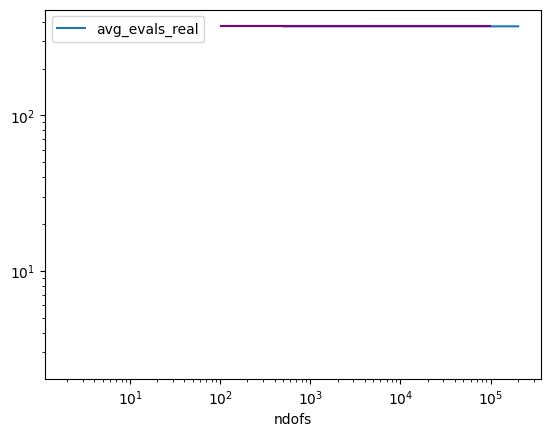

In [90]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

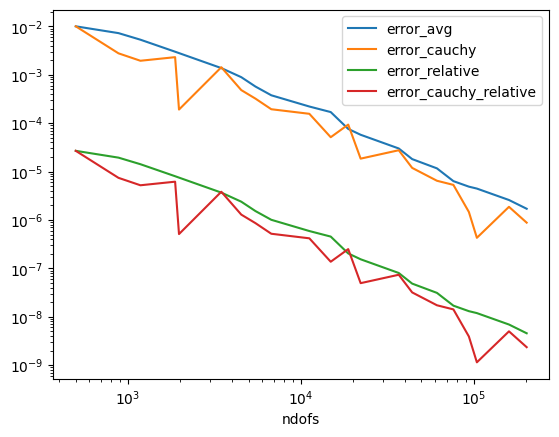

In [91]:
err_df.plot(x="ndofs", loglog=True)

In [92]:
get_numerical_error_order(
    err_df,
    err_df.columns.drop(["error_cauchy", "error_relative", "error_cauchy_relative"]),
)
get_numerical_error_order(
    err_df, err_df.columns.drop(["error_cauchy", "error_avg", "error_cauchy_relative"])
)
print(
    err_df[
        err_df.columns.drop(
            ["error_avg", "error_cauchy", "error_relative", "error_cauchy_relative"]
        )
    ]
)

     ndofs  error_avg_order  error_relative_order
0      501         0.000000              0.000000
1      885         0.568920              0.568920
2     1185         1.070989              1.070989
3     1881         1.237284              1.237284
4     1981         1.272178              1.272178
5     3480         1.266221              1.266221
6     4539         1.626790              1.626790
7     5483         2.363944              2.363944
8     6770         1.969307              1.969307
9    11237         1.055608              1.055608
10   14938         0.927840              0.927840
11   18857         3.440435              3.440435
12   22249         1.683599              1.683599
13   36950         1.285313              1.285313
14   44185         2.827576              2.827576
15   61460         1.336840              1.336840
16   76516         2.774616              2.774616
17   94026         1.271846              1.271846
18  104590         0.861561              0.861561


## Eigenvalue problem for the original convection diffusion eq., dual error estimator

### FEAST

In [93]:
matrix = CoefficientFunction((1, 0, 0, 1), dims=(2, 2))
vector = CoefficientFunction((0.0, 0.0))
scalar = CoefficientFunction(325.0)
mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))

eta_dict, eig_dict, err_dict, sol = test_ard_eig_feast_dual(
    parameters=parameters,
    matrix_coeff=matrix,
    vector_coeff=vector,
    scalar_coeff=scalar,
    **feast_parameters,
)

	Parameters: {'order': 2, 'maxiter': 100, 'maxndofs': 200000, 'center': 374.3480220054468, 'radius': 0.1, 'npts': 6, 'nspan': 4, 'maxh': 0.15, 'theta': 0.5}

SpectralProj: Setting shifted trapezoidal rule quadrature on circular contour
SpectralProj: Radius=0.01, Center=374.348+0j

SpectralProjNG: Computing resolvents using umfpack
SpectralProjNG:   Factorizing at z = +374.355 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 -0.007j
SpectralProjNG:   Factorizing at z = +374.355 -0.007j

=========== Starting FEAST iterations ===========
Trying with 2 vectors:

 ITERATION 1 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [3.2e-05 6.8e-04]
   Real part of computed eigenvalues:
   [374.35759663 374.35851288]
   Relative Hausdorff distance from prior iterate: 2.671e+97

 ITERATION 2 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [3783.4  323.1]
   Real part of computed eigenvalues:
   [3

In [94]:
Draw(sol["u"], sol["mesh"], name="Landscape solution")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [95]:
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

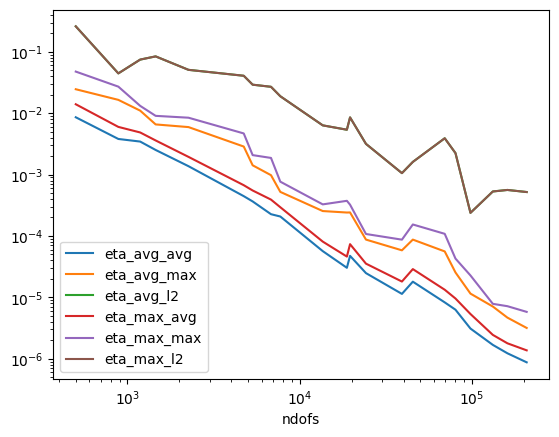

In [96]:
eta_df.plot(x="ndofs", loglog=True)

In [97]:
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_avg_l2", "eta_max_avg", "eta_max_max"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_avg_l2", "eta_max_avg", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_avg_l2", "eta_max_max", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_max", "eta_max_avg", "eta_max_max", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_avg", "eta_avg_l2", "eta_max_avg", "eta_max_max", "eta_max_l2"]
    ),
)
get_numerical_error_order(
    eta_df,
    eta_df.columns.drop(
        ["eta_avg_max", "eta_avg_l2", "eta_max_avg", "eta_max_max", "eta_max_l2"]
    ),
)
print(
    eta_df[
        eta_df.columns.drop(
            [
                "eta_avg_avg",
                "eta_avg_max",
                "eta_avg_l2",
                "eta_max_avg",
                "eta_max_max",
                "eta_max_l2",
            ]
        )
    ]
)

     ndofs  eta_max_l2_order  eta_max_max_order  eta_max_avg_order  \
0      501          0.000000           0.000000           0.000000   
1      885          3.103101           0.992531           1.493343   
2     1185         -1.772878           2.470867           0.715096   
3     1457         -0.580926           1.813460           1.450744   
4     2260          1.149291           0.158522           1.403092   
5     4729          0.301034           0.799329           1.438697   
6     5327          2.809141           6.829011           1.668707   
7     6807          0.323810           0.430777           1.394222   
8     7711          2.847240           7.145203           2.299405   
9    13595          1.925054           1.501721           2.273381   
10   18766          0.508037          -0.414042           1.741866   
11   19578        -10.911324           3.408363         -10.991989   
12   24218          4.669352           5.171692           3.435984   
13   39161          

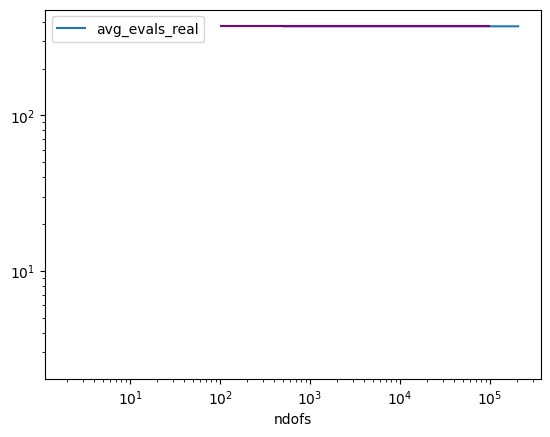

In [98]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

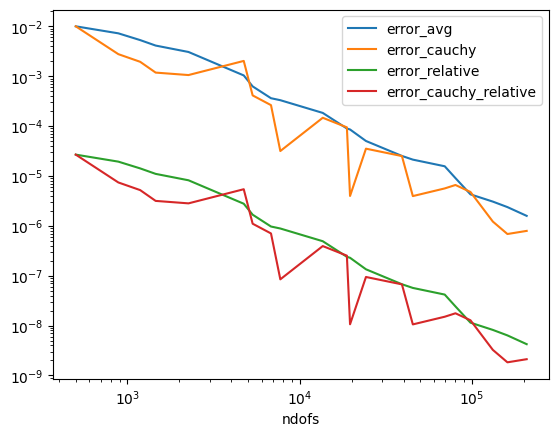

In [99]:
err_df.plot(x="ndofs", loglog=True)

In [100]:
get_numerical_error_order(
    err_df,
    err_df.columns.drop(["error_cauchy", "error_relative", "error_cauchy_relative"]),
)
get_numerical_error_order(
    err_df, err_df.columns.drop(["error_cauchy", "error_avg", "error_cauchy_relative"])
)
print(
    err_df[
        err_df.columns.drop(
            ["error_avg", "error_cauchy", "error_relative", "error_cauchy_relative"]
        )
    ]
)

     ndofs  error_avg_order  error_relative_order
0      501         0.000000              0.000000
1      885         0.568920              0.568920
2     1185         1.070989              1.070989
3     1457         1.221101              1.221101
4     2260         0.674141              0.674141
5     4729         1.466875              1.466875
6     5327         4.253856              4.253856
7     6807         2.227054              2.227054
8     7711         0.732248              0.732248
9    13595         1.035506              1.035506
10   18766         2.233496              2.233496
11   19578         1.070150              1.070150
12   24218         2.498515              2.498515
13   39161         1.436255              1.436255
14   45311         1.167143              1.167143
15   69389         0.720597              0.720597
16   80098         3.812087              3.812087
17   97882         3.739157              3.739157
18  131987         1.119983              1.119983


### Arnoldi

In [101]:
matrix = CoefficientFunction((1, 0, 0, 1), dims=(2, 2))
vector = CoefficientFunction((20.0, 30.0))
scalar = CoefficientFunction(0.0)
mesh = Mesh(make_unit_square().GenerateMesh(maxh=MAXH))

eta_dict, eig_dict, err_dict, sol = test_ard_dual(
    parameters=parameters,
    matrix_coeff=matrix,
    vector_coeff=vector,
    scalar_coeff=scalar,
    source_coeff=None,
    **feast_parameters,
)

	Parameters: {'order': 2, 'maxiter': 100, 'maxndofs': 200000, 'center': 374.3480220054468, 'radius': 0.1, 'npts': 6, 'nspan': 4, 'maxh': 0.15, 'theta': 0.5}

SpectralProj: Setting shifted trapezoidal rule quadrature on circular contour
SpectralProj: Radius=0.01, Center=374.348+0j

SpectralProjNG: Computing resolvents using umfpack
SpectralProjNG:   Factorizing at z = +374.355 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 +0.007j
SpectralProjNG:   Factorizing at z = +374.341 -0.007j
SpectralProjNG:   Factorizing at z = +374.355 -0.007j

=========== Starting FEAST iterations ===========
Trying with 2 vectors:

 ITERATION 1 with 2 vectors and 2 left vectors
   During kernel cleaning abs(g):
   [2.0e-27 9.5e-19]
   Real part of computed eigenvalues:
   [377.88901648 378.87840721]
   Imag part of computed eigenvalues:
   [ 8.74633665e-08 -1.24488619e+01]
   Relative Hausdorff distance from prior iterate: 2.671e+97

 ITERATION 2 with 2 vectors and 2 left vectors
   During kernel clea

In [102]:
Draw(sol["u"], sol["mesh"], name="Landscape solution")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [103]:
to_file(eta_dict, "etas_eig_dual.csv")
to_file(eig_dict, "eval_eig_dual.csv")
to_file(err_dict, "errs_eig_dual.csv")
eta_df = pd.DataFrame(eta_dict)
eig_df = pd.DataFrame(eig_dict)
err_df = pd.DataFrame(err_dict)

<Axes: xlabel='ndofs'>

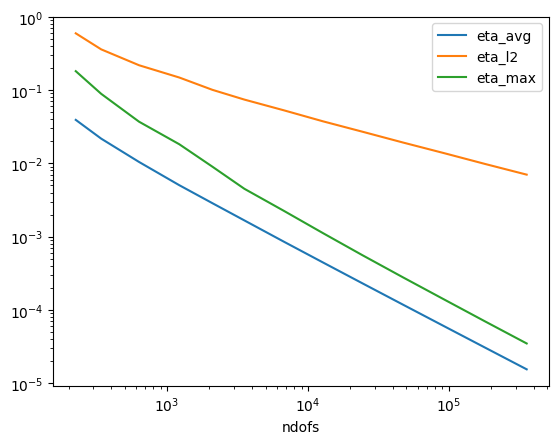

In [104]:
eta_df.plot(x="ndofs", loglog=True)

In [105]:
get_numerical_error_order(eta_df, eta_df.columns.drop(["eta_avg", "eta_max"]))
get_numerical_error_order(eta_df, eta_df.columns.drop(["eta_avg", "eta_l2"]))
get_numerical_error_order(eta_df, eta_df.columns.drop(["eta_max", "eta_l2"]))
print(eta_df[eta_df.columns.drop(["eta_avg", "eta_max", "eta_l2"])])

     ndofs  eta_l2_order  eta_max_order  eta_avg_order
0      225      0.000000       0.000000       0.000000
1      341      1.213745       1.714501       1.420012
2      633      0.807111       1.416522       1.185568
3     1221      0.586907       1.078162       1.110768
4     2098      0.715115       1.303922       1.045107
5     3540      0.587605       1.329783       1.037057
6     6768      0.522350       1.074684       1.036343
7    12792      0.541840       1.096168       1.022649
8    24377      0.506585       1.076622       1.017192
9    47178      0.512857       1.050576       1.011892
10   92212      0.497391       1.034895       1.008264
11  180648      0.507914       1.031107       1.005989
12  356383      0.493822       1.020334       1.004028


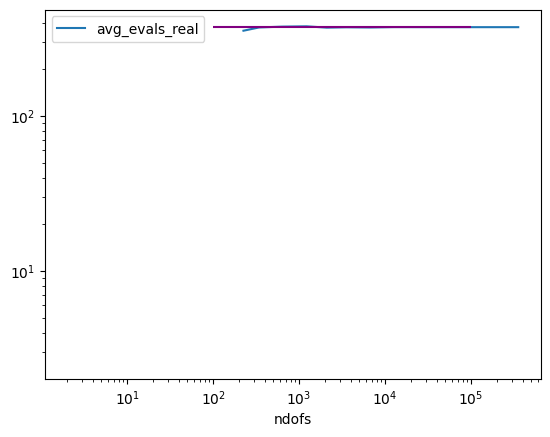

In [106]:
ax = eig_df.drop(["avg_evals", "avg_evals_imag"], axis=1).plot(x="ndofs", loglog=True)
ax.hlines(y=CENTER, xmin=100, xmax=100000, color="purple", label="test")

<Axes: xlabel='ndofs'>

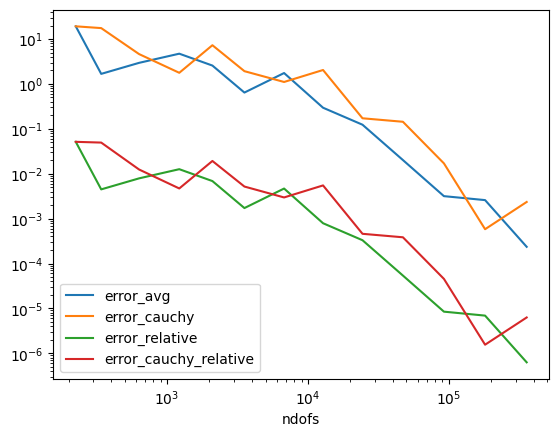

In [107]:
err_df.plot(x="ndofs", loglog=True)

In [108]:
get_numerical_error_order(
    err_df,
    err_df.columns.drop(["error_cauchy", "error_relative", "error_cauchy_relative"]),
)
get_numerical_error_order(
    err_df, err_df.columns.drop(["error_cauchy", "error_avg", "error_cauchy_relative"])
)
print(
    err_df[
        err_df.columns.drop(
            ["error_avg", "error_cauchy", "error_relative", "error_cauchy_relative"]
        )
    ]
)

     ndofs  error_avg_order  error_relative_order
0      225         0.000000              0.000000
1      341         5.866373              5.866373
2      633        -0.913745             -0.913745
3     1221        -0.715755             -0.715755
4     2098         1.125152              1.125152
5     3540         2.647404              2.647404
6     6768        -1.544732             -1.544732
7    12792         2.794680              2.794680
8    24377         1.352034              1.352034
9    47178         2.745294              2.745294
10   92212         2.762957              2.762957
11  180648         0.301614              0.301614
12  356383         3.526411              3.526411
